In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
def format_ticks(y, _):
        # Format with 2 decimals
        s = f'{y:.3f}'
        # Remove trailing zeros and dot if needed
        if '.' in s:
            s = s.rstrip('0').rstrip('.')
        # Remove leading zero before decimal point
        if s.startswith('0.') or s.startswith('-0.'):
            s = s.replace('0.', '.')
        return s

In [30]:
results_df = pd.read_csv("../../results/random_targets_wasserstein_all_tissues_with_samples.csv", index_col=0)
bins = [0, 500, 1000, float('inf')]
labels = ['Small', 'Medium', 'Large']
results_df['sample_bin'] = pd.cut(results_df['num_samples'], bins=bins, labels=labels, right=False)
results_df['speedup_factor_log10'] = results_df['rel_emission_saving'] / 100
subset = results_df[results_df['num_non_tfs'].isin([1,10,20,30,40,50,60,70,80,90,100])]
speedup_df = (
    subset.groupby(['sample_bin', 'num_non_tfs'], as_index=False)
        ['speedup_factor_log10']
        .mean()
    )

# --- Pivot for second heatmap ---
speedup_wide = speedup_df.pivot(index='sample_bin', columns='num_non_tfs', values='speedup_factor_log10')
speedup_wide = speedup_wide.sort_index().sort_index(axis=1)
speedup_wide

/tmp/ipykernel_822526/3520891432.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby(['sample_bin', 'num_non_tfs'], as_index=False)


num_non_tfs,1,10,20,30,40,50,60,70,80,90,100
sample_bin,,,,,,,,,,,
Small,1.948294,1.803503,1.571959,1.409352,1.237834,1.170847,1.126203,0.962451,0.940113,0.937961,0.848996
Medium,3.298760,2.585649,2.534157,2.523897,1.861672,1.821673,1.681171,1.520689,1.289852,1.336323,1.067417
Large,4.008260,3.472608,3.273027,3.027148,2.382784,2.006597,1.856102,1.493667,1.518689,1.470099,1.206771


In [77]:
random_df = pd.read_csv("../../results/random_targets_wasserstein_results.csv")
medoid_df = pd.read_csv("../../results/medoid_targets_wasserstein_results.csv")
random_bh_df = pd.read_csv("../../results/random_targets_wasserstein_benjamini_corrected.csv")
medoid_bh_df = pd.read_csv("../../results/medoid_targets_wasserstein_benjamini_corrected.csv")
# Merge respective dataframes.
random_df['Representative'] = 'Random'
medoid_df['Representative'] = 'Medoid'
random_bh_df['Representative'] = 'Random'
medoid_bh_df['Representative'] = "Medoid"
plot_df = pd.concat([random_df, medoid_df], ignore_index=True)
plot_df = plot_df[plot_df['num_non_tfs']<= 100]
plot_bh_df = pd.concat([random_bh_df, medoid_bh_df], ignore_index=True)
plot_df.rename(columns={'tissue' : "Tissue"}, inplace=True)
plot_bh_df.rename(columns={'tissue' : "Tissue"}, inplace=True)

# Prepare runtimes dfs for random and medoids.
random_df['runtime_h'] = random_df['total_runtime'] / 60.0
subset = random_df[random_df['num_non_tfs'].isin([1,10,20,30,40,50,60,70,80,90,100])]

# --- Pivot for second heatmap ---
random_times = subset.pivot(index='tissue', columns='num_non_tfs', values='runtime_h')
random_wide = random_times.sort_index().sort_index(axis=1)

medoid_df['runtime_h'] = medoid_df['total_runtime'] / 60.0
subset = medoid_df[medoid_df['num_non_tfs'].isin([1,10,20,30,40,50,60,70,80,90,100])]

# --- Pivot for second heatmap ---
medoid_times = subset.pivot(index='tissue', columns='num_non_tfs', values='runtime_h')
medoid_wide = medoid_times.sort_index().sort_index(axis=1)


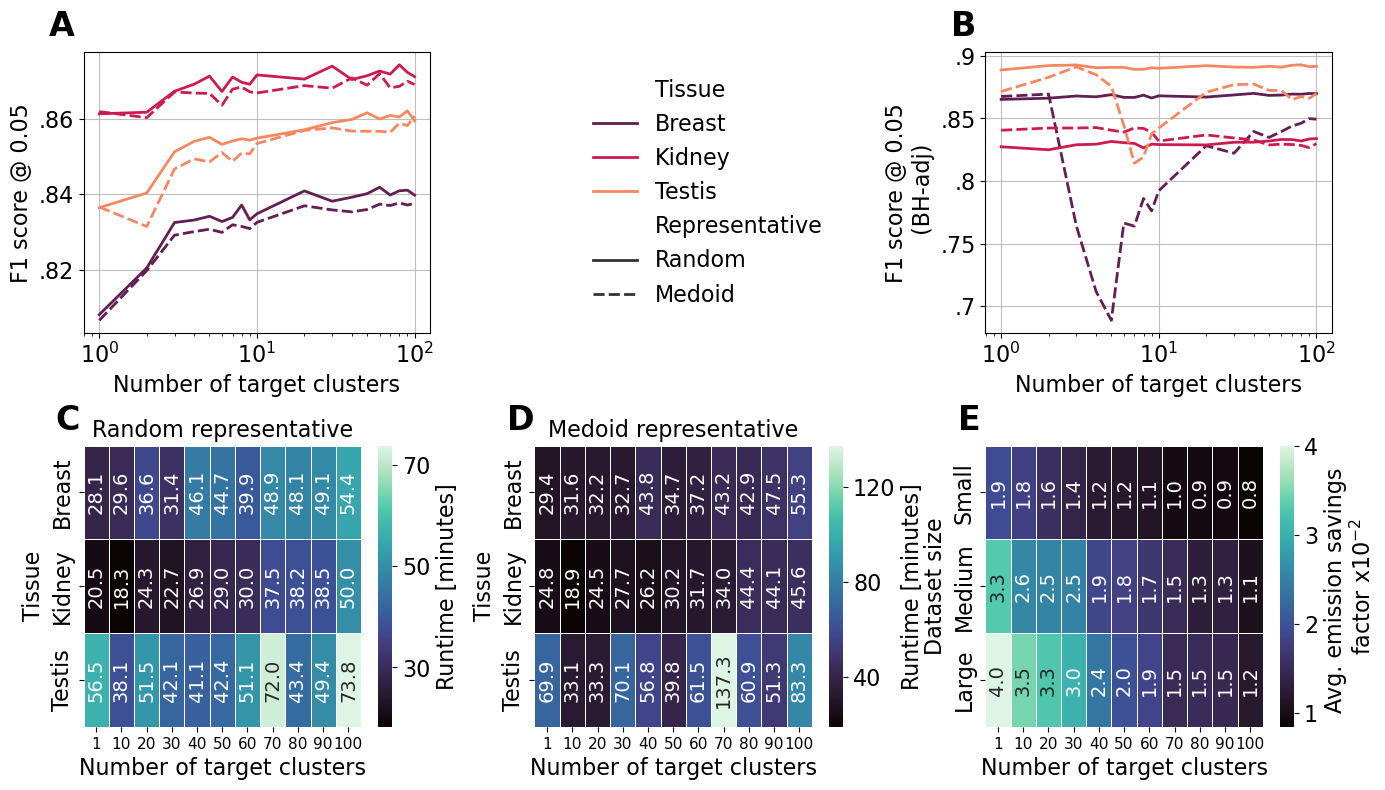

In [98]:
# Create one large mosaic plot.
fig, axs = plt.subplot_mosaic([['A', 'B', 'C'], ['D', 'E', 'F']])
fig.set_size_inches(14, 8)
axs_list = list(axs.values())
label_fontsize = 16

### GENIE3 Plots.
line1 = sns.lineplot(
data=plot_df,
x='num_non_tfs',
y='f1_005',
ax=axs['A'],
palette=sns.color_palette("rocket", 3),
linewidth=2.0,
hue='Tissue',
style="Representative",
legend=False
)

axs['A'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
axs['A'].set_ylabel('F1 score @ 0.05', fontsize=label_fontsize)
axs['A'].tick_params(axis='x', labelsize=label_fontsize)
axs['A'].tick_params(axis='y', labelsize=label_fontsize)
formatter = FuncFormatter(format_ticks)
axs['A'].yaxis.set_major_formatter(formatter)
axs['A'].grid(True, alpha=0.8)
axs['A'].set_xscale('log')

    
line2 = sns.lineplot(
    data=plot_bh_df,
    x='num_non_tfs',
    y='f1_005',
    ax=axs['C'],
    palette=sns.color_palette("rocket", 3),
    linewidth=2.,
    hue="Tissue",
    style="Representative",
    legend='auto'
)
handles, labels = axs['C'].get_legend_handles_labels()

    # 2️⃣ Create legend inside the blank axis
axs['B'].legend(
    handles,
    labels,
    loc='center',
    ncol=1,
    frameon=False,
    fontsize=label_fontsize,
    title=None
)
axs['B'].axis('off')  # hide frame, ticks, etc.
#legend = axs['B'].legend(title=None, fontsize=label_fontsize)  # set font size for entries
#legend.set_title(None)  # just to be explicit, removes title if Seaborn adds one
# Remove legend from this subplot only
if axs['C'].get_legend() is not None:
    axs['C'].get_legend().remove()
axs['C'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
axs['C'].set_ylabel("F1 score @ 0.05\n (BH-adj)", fontsize=label_fontsize)
axs['C'].tick_params(axis='x', labelsize=label_fontsize)
axs['C'].tick_params(axis='y', labelsize=label_fontsize)
formatter = FuncFormatter(format_ticks)
# Apply to y-axis
axs['C'].yaxis.set_major_formatter(formatter)
axs['C'].grid(True, alpha=0.8)
axs['C'].set_xscale('log')

heat3 = sns.heatmap(
    random_wide,
    cmap="mako",
    linewidths=0.5,
    linecolor='white',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': "Runtime [minutes]"},
    ax=axs['D'],
    annot_kws={
        "size": label_fontsize-2,
        "rotation": 90,     # rotate text inside cells (degrees)
        "ha": "center",     # horizontal alignment (e.g., 'center', 'left', 'right')
        "va": "center"      # vertical alignment (e.g., 'center', 'top', 'bottom')
    }
)

cbar = heat3.collections[0].colorbar
cbar.set_ticks([30, 50, 70])
cbar.ax.yaxis.label.set_size(label_fontsize)
cbar.ax.tick_params(labelsize=label_fontsize)
axs['D'].set_title("Random representative", fontsize=label_fontsize)
axs['D'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
axs['D'].set_ylabel('Tissue', fontsize=label_fontsize)
axs['D'].tick_params(axis='x', labelsize=label_fontsize-5)
axs['D'].tick_params(axis='y', labelsize=label_fontsize)

heat4 = sns.heatmap(
    medoid_wide,
    cmap="mako",
    linewidths=0.5,
    linecolor='white',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': "Runtime [minutes]"},
    ax=axs['E'],
    annot_kws={
        "size": label_fontsize-2,
        "rotation": 90,     # rotate text inside cells (degrees)
        "ha": "center",     # horizontal alignment (e.g., 'center', 'left', 'right')
        "va": "center"      # vertical alignment (e.g., 'center', 'top', 'bottom')
    }
)

cbar = heat4.collections[0].colorbar
cbar.set_ticks([40, 80, 120])
cbar.ax.yaxis.label.set_size(label_fontsize)
cbar.ax.tick_params(labelsize=label_fontsize)
axs['E'].set_title("Medoid representative", fontsize=label_fontsize)
axs['E'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
axs['E'].set_ylabel('Tissue', fontsize=label_fontsize)
axs['E'].tick_params(axis='x', labelsize=label_fontsize-5)
axs['E'].tick_params(axis='y', labelsize=label_fontsize)
    
heat2 = sns.heatmap(
    speedup_wide,
    cmap="mako",
    linewidths=0.5,
    linecolor='white',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': "Avg. emission savings \nfactor x$10^{-2}$"},
    ax=axs['F'],
    annot_kws={
        "size": label_fontsize-2,
        "rotation": 90,     # 🔹 rotate text inside cells (degrees)
        "ha": "center",     # horizontal alignment (e.g., 'center', 'left', 'right')
        "va": "center"      # vertical alignment (e.g., 'center', 'top', 'bottom')
    }
)

cbar = heat2.collections[0].colorbar
cbar.set_ticks([1.0, 2.0, 3.0, 4.0])
cbar.ax.yaxis.label.set_size(label_fontsize)
cbar.ax.tick_params(labelsize=label_fontsize)
axs['F'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
axs['F'].set_ylabel('Dataset size', fontsize=label_fontsize)
axs['F'].tick_params(axis='x', labelsize=label_fontsize-5)
axs['F'].tick_params(axis='y', labelsize=label_fontsize)

labels = {'A': 'A', 'B': '', 'C': 'B', 'D': 'C', 'E' : 'D', 'F' : 'E'}

for key, label in labels.items():
    ax = axs[key]
    ax.text(
        -0.1, 1.15, label,
        transform=ax.transAxes,
        fontsize=24,
        fontweight='bold',
        va='top',
        ha='left'
    )

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig("supplement_random_vs_medoid.pdf", format='pdf', bbox_inches='tight')
